# Análise do Titanic - Parte 2

## Importando as bases de dados de treino e teste

In [2]:
import pandas as pd

In [3]:
treino = pd.read_csv('DataBase/train.csv')
treino.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
teste = pd.read_csv('DataBase/test.csv')
teste.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


* Realizando a mesma limpeza feita na **Parte 1**

1. Eliminando colunas com alta cardinalidade

In [5]:
treino = treino.drop(['Name', 'Ticket', 'Cabin'], axis=1)
teste = teste.drop(['Name', 'Ticket', 'Cabin'], axis=1)

2. Utilizando a média para substituir valores nulos na coluna de idade pela média

In [6]:
treino.loc[treino.Age.isnull(), 'Age'] = treino.Age.mean()
teste.loc[teste.Age.isnull(), 'Age'] = teste.Age.mean()

3. Tratando valores nulos na coluna Embarked pela moda

In [7]:
treino.loc[treino.Embarked.isnull(), 'Embarked'] = treino.Embarked.mode()[0]

4. Por fim, utilizando a média para tratar os valores da coluna Fare na base de teste

In [8]:
teste.loc[teste.Fare.isnull(), 'Fare'] = teste.Fare.mean()

## Agora, precisamos entender as colunas de texto

In [9]:
treino.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
dtype: object

In [10]:
treino.dtypes == 'object'

PassengerId    False
Survived       False
Pclass         False
Sex             True
Age            False
SibSp          False
Parch          False
Fare           False
Embarked        True
dtype: bool

In [11]:
treino.columns[treino.dtypes == 'object']

Index(['Sex', 'Embarked'], dtype='object')

In [12]:
treino.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [13]:
treino.Embarked.value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

* A coluna Sex possui valores binários. Assim, podemos validar essa coluna como: 
    - cria-se uma coluna "MaleCheck" onde ela recebe o valor 1 se for masculina (male) e 0 se for feminino (female)

In [14]:
treino['MaleCheck'] = treino.Sex.apply(lambda x: 1 if x == 'male' else 0)

* Aqui, utiliza-se a lambda function para atribiur os valores para cada linha da coluna Sex.

In [15]:
treino[['Sex', 'MaleCheck']].value_counts()

Sex     MaleCheck
male    1            577
female  0            314
Name: count, dtype: int64

In [16]:
teste['MaleCheck'] = teste.Sex.apply(lambda x: 1 if x == 'male' else 0)

In [17]:
teste[['Sex', 'MaleCheck']].value_counts()

Sex     MaleCheck
male    1            266
female  0            152
Name: count, dtype: int64

* Agora precisamos tratar a coluna Embarked, a qual não é binária, existem 3 valores para serem checados:
    - utiliza-se OneHotEncoder que irá criar uma nova coluna **para cada um dos rótulos** da coluna original
    - O **OneHotEnconder** atribuir os valores binários para estas novas colunas, isto é, atribui 1 para a coluna que possuir o valor da coluna Embarked

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
ohe = OneHotEncoder(handle_unknown='ignore', dtype='int32')

In [20]:
ohe = ohe.fit(treino[['Embarked']])

In [21]:
ohe.transform(treino[['Embarked']]).toarray()

array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]])

In [22]:
ohe_df = pd.DataFrame(ohe.transform(treino[['Embarked']]).toarray(), columns=ohe.get_feature_names_out())
ohe_df.head(3)

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1


In [23]:
treino = pd.concat([treino, ohe_df], axis=1)

In [24]:
treino.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,male,22.0,1,0,7.2500,S,1,0,0,1
1,2,1,1,female,38.0,1,0,71.2833,C,0,1,0,0
2,3,1,3,female,26.0,0,0,7.9250,S,0,0,0,1


In [25]:
treino[['Embarked', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].value_counts()

Embarked  Embarked_C  Embarked_Q  Embarked_S
S         0           0           1             646
C         1           0           0             168
Q         0           1           0              77
Name: count, dtype: int64

In [26]:
ohe_df = pd.DataFrame(ohe.transform(teste[['Embarked']]).toarray(), columns=ohe.get_feature_names_out())

In [27]:
teste = pd.concat([teste, ohe_df], axis=1)

In [30]:
teste.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,892,3,male,34.5,0,0,7.8292,Q,1,0,1,0
1,893,3,female,47.0,1,0,7.0000,S,0,0,0,1
2,894,2,male,62.0,0,0,9.6875,Q,1,0,1,0


In [31]:
base_teste_parte2 = teste
base_teste_parte2.to_csv('base_teste_parte2.csv', index=False)

In [28]:
teste[['Embarked', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].value_counts()

Embarked  Embarked_C  Embarked_Q  Embarked_S
S         0           0           1             270
C         1           0           0             102
Q         0           1           0              46
Name: count, dtype: int64

### Vamos utilizar esta nova base nos modelos de Machine Learning

In [29]:
treino.head(3)

base_parte2 = treino
base_parte2.to_csv('base_parte2.csv', index=False)

In [91]:
treino = treino.drop(['Sex', 'Embarked'], axis=1)
teste = teste.drop(['Sex', 'Embarked'], axis=1)

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [92]:
X = treino.drop(['PassengerId', 'Survived'], axis=1)
y = treino.Survived

In [95]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

* Árvore de Decisão por Classificação

In [97]:
from sklearn import tree

clf_ac = tree.DecisionTreeClassifier(random_state=42)
clf_ac = clf_ac.fit(X_train, y_train)
y_pred_ac = clf_ac.predict(X_val)

In [104]:
accuracy_score(y_val, y_pred_ac)

0.7491525423728813

* KNN

In [98]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn = clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_val)

In [105]:
accuracy_score(y_val, y_pred_knn)

0.7152542372881356

* Regressão Logística

In [102]:
from sklearn.linear_model import LogisticRegression

clf_rl = LogisticRegression(random_state=42, max_iter=2000)
clf_rl = clf_rl.fit(X_train, y_train)
y_pred_rl = clf_rl.predict(X_val)

In [106]:
accuracy_score(y_val, y_pred_rl)

0.8169491525423729

* Aqui, vale a pena perceber como a acurácia aumentou em relação ao último projeto em Parte1.ipynb

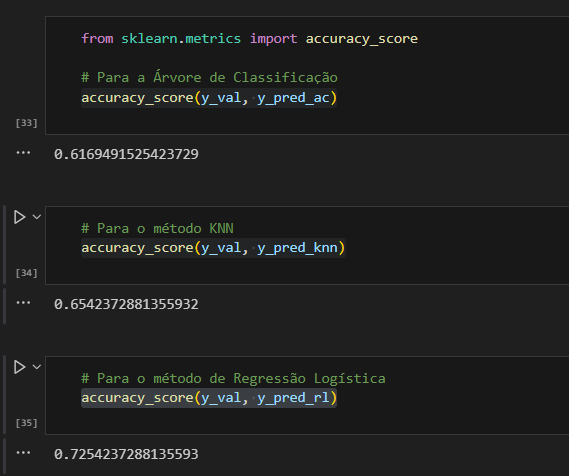

* Agora, podemos realizar a previsão da base de teste com o modelo com maior acurácia (é a métrica considerada aqui): Regressão Logística

In [107]:
X_train.head(3)

,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
6,1,54.000000,0,0,51.8625,1,0,0,1
718,3,29.699118,0,0,15.5000,1,0,1,0
685,2,25.000000,1,2,41.5792,1,1,0,0


In [108]:
teste.head(3)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,1,0,1,0
1,893,3,47.0,1,0,7.0000,0,0,0,1
2,894,2,62.0,0,0,9.6875,1,0,1,0


* Podemos perceber que a base de treino e a base de teste diferenciam-se pela coluna 'PassengerId', por isso precisamos retirar esta coluna da base de teste;

In [110]:
X_teste = teste.drop('PassengerId', axis=1)

* Realizando a previsão com o modelo de Regressão Logística

In [111]:
y_pred = clf_rl.predict(X_teste)

* Adicionando a coluna 'Survived' e 'PassengerId' para enviar o arquivo para validação no Kaggle

In [112]:
teste['Survived'] = y_pred

In [115]:
base_envio = teste[['PassengerId', 'Survived']]

In [117]:
base_envio.to_csv('titanic_previsao_2.csv', index=False)